In [3]:
# Import packages
import geopandas as gpd
import numpy as np
import pandas as pd
import os
import re
from shapely.geometry import Polygon, MultiPolygon
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from rasterstats import zonal_stats
from osgeo import gdal
import rasterio
import rasterstats
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

import sys
sys.path.append(os.path.abspath("D:/other_thesis/clean_sheet/codes/functions/"))
import functions_model #import python file containing the functions

import warnings
warnings.filterwarnings('ignore')

In [4]:
# For updates
import importlib
importlib.reload(functions_model)

<module 'functions_model' from 'D:\\other_thesis\\clean_sheet\\codes\\functions\\functions_model.py'>

In [5]:
Karnataka_shp = gpd.read_file(r'C:\Users\mieke\Documents\Msc Thesis\Datasets\Shapefiles\Karnataka_state_shp\State.shp')
Karnataka_shp.geometry = Karnataka_shp.geometry.to_crs(epsg = 4326) # Set crs to 4326

Karnataka_districts = gpd.read_file(r'C:\Users\mieke\Documents\Msc Thesis\Datasets\Shapefiles\District_2016\District_2016.shp')
Karnataka_districts.geometry = Karnataka_districts.geometry.to_crs(epsg = 4326) # Set crs to 4326

In [6]:
data_paddy = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_pre\paddy_kharif_params_touched_large.geojson')

In [75]:
dataset = data_paddy.copy()
print(np.size(dataset,0))
data = dataset[dataset['Average Yield(Kg/Ha)'] != 0] # Throw away average yield values of zero, 13.366 datapoints left (6581 - 6556 = 25)

data = data[data['Gram Panchayat/Hobli'] == 'gp'] # 6058
#data = data.dropna(axis=0) # No missing values
print(np.size(data,0))

6340
6315


In [8]:
district_yield = pd.read_excel('D:/Data_download/Other/yield_district/district_yields.xlsx')

In [9]:
district_paddy_2015 = district_yield[(district_yield['Crop'] == 'paddy') & (district_yield['Year'] == 2015) & (district_yield['Season'] == 'Kharif')]
district_paddy_2016 = district_yield[(district_yield['Crop'] == 'paddy') & (district_yield['Year'] == 2016) & (district_yield['Season'] == 'Kharif')]
district_paddy_2017 = district_yield[(district_yield['Crop'] == 'paddy') & (district_yield['Year'] == 2017) & (district_yield['Season'] == 'Kharif')]
district_paddy_2018 = district_yield[(district_yield['Crop'] == 'paddy') & (district_yield['Year'] == 2018) & (district_yield['Season'] == 'Kharif')]

Karnataka_districts.crs
Karnataka_districts['District'] = Karnataka_districts['KGISDist_1'].str.lower()
district_paddy_2015 = district_paddy_2015.merge(Karnataka_districts[['District', 'geometry']], how = 'left', on = ['District'])
district_paddy_2016 = district_paddy_2016.merge(Karnataka_districts[['District', 'geometry']], how = 'left', on = ['District'])
district_paddy_2017 = district_paddy_2017.merge(Karnataka_districts[['District', 'geometry']], how = 'left', on = ['District'])
district_paddy_2018 = district_paddy_2018.merge(Karnataka_districts[['District', 'geometry']], how = 'left', on = ['District'])

district_paddy_2015 = gpd.GeoDataFrame(district_paddy_2015, geometry = district_paddy_2015.geometry, crs = {'init': 'epsg:4326'})
district_paddy_2016 = gpd.GeoDataFrame(district_paddy_2016, geometry = district_paddy_2016.geometry, crs = {'init': 'epsg:4326'})
district_paddy_2017 = gpd.GeoDataFrame(district_paddy_2017, geometry = district_paddy_2017.geometry, crs = {'init': 'epsg:4326'})
district_paddy_2018 = gpd.GeoDataFrame(district_paddy_2018, geometry = district_paddy_2018.geometry, crs = {'init': 'epsg:4326'})

In [10]:
sizes = pd.DataFrame({'Count': data.groupby('District').size()}).reset_index()
obs_count_district = Karnataka_districts[['District', 'geometry']].merge(sizes, how = 'left', on = ['District']).fillna(0).sort_values('Count', ascending = False, ignore_index = True)

In [11]:
def predictor_plot(data_predictors, predictor:str, unit: str):
    avg = data_predictors.groupby(['Month'])[predictor].mean().reset_index()
    avg['Month_text'] = 0
    for i in range(0, len(avg)):
            avg['Month_text'].iloc[i] = calendar.month_name[avg['Month'].iloc[i]] 
    
    myFmt = mdates.DateFormatter('%Y-%b') 
    avg_date = data_predictors.groupby(['Date'])[predictor].mean().reset_index()
    #avg_date['Date'] = avg_date['Date'].astype(str)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20, 4))

    ax1.plot(avg_date['Date'], avg_date[predictor])
    ax1.set_xlabel('Date', fontsize = 15)
    ax1.set_ylabel(unit, fontsize = 15)
    ax1.set_xticklabels(avg_date['Date'], rotation=45)
    ax1.xaxis.set_major_formatter(myFmt)
    ax2.plot(avg['Month_text'], avg[predictor])
    ax2.set_xlabel('Month', fontsize = 15)
    ax2.set_xticklabels(avg['Month_text'], rotation=45)

    
    return plt.show()

In [54]:
def plot_features_time(var, df, y_unity, y_lim):
    myFmt = mdates.DateFormatter('%Y-%b')
    matplotlib.rcParams.update({'font.size': 20})
    fig,ax = plt.subplots(figsize=(14,8))
    param = ['mean', 'median', 'min', 'max', 'percentile_10', 'percentile_90']
    legend_labels = ['mean', 'median', 'min', 'max', '0.10 quantile', '0.90 quantile']
    units = []
    for i in range(len(param)):
        temp = df.loc[:,[col for col in df.columns if param[i] in col]].mean()
        temp.index = [re.search('(.*?)\_.[a-z]', x).group(1) for x in temp.index]
        temp.index = pd.to_datetime(temp.index)
        plt.plot(temp.index, temp, label= legend_labels[i])
    ax.set_xticklabels(temp.index, rotation=45)
    ax.xaxis.set_major_formatter(myFmt)
    plt.xlabel('Date')#, fontsize = 20)
    plt.ylabel(y_unity)#, fontsize = 20)
    plt.legend(loc = 'upper left', fontsize=15)
    plt.ylim(y_lim)
    plt.savefig('D:/other_thesis/clean_sheet/files/analysis/plots/' + var + '.png', bbox_inches='tight')
    plt.show()

In [13]:
data['geometry_str'] = data['geometry'].astype(str)
unique_paddy = data.drop_duplicates(subset = ['geometry_str'])
unique_paddy = pd.concat([unique_paddy.iloc[:,:10], unique_paddy.geometry], axis=1)
#data.drop_duplicates(subset = ['shapeName', 'Taluk']).drop_duplicates(subset = ['geometry_str'])#, 'District']) # 2213

In [69]:
data_2016 = data[data['Year'] == 2016]
data_2017 = data[data['Year'] == 2017]
data_2018 = data[data['Year'] == 2018]

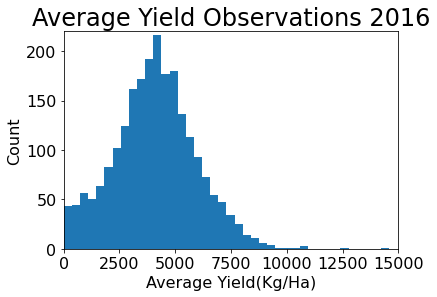

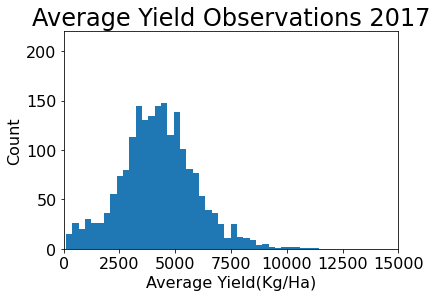

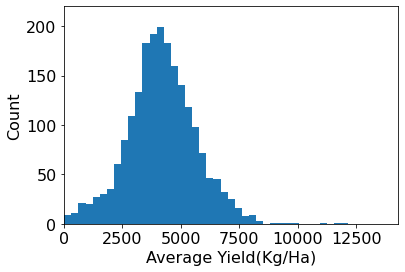

In [130]:
# distributie van de absolute differences (899 is de MAE)
plt.hist(data_2016['Average Yield(Kg/Ha)'], bins = 40)
plt.title('Average Yield Observations 2016')
plt.xlabel('Average Yield(Kg/Ha)', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlim([0,15000])
plt.ylim([0,220])
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\distributions\dist_time_diff.png', bbox_inches='tight')
plt.show()

# distributie van de absolute differences (899 is de MAE)
plt.hist(data_2017['Average Yield(Kg/Ha)'], bins = 40)
plt.title('Average Yield Observations 2017')
plt.xlabel('Average Yield(Kg/Ha)', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlim([0,15000])
plt.ylim([0,220])
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\distributions\dist_time_diff.png', bbox_inches='tight')
plt.show()

# distributie van de absolute differences (899 is de MAE)
plt.hist(data_2018['Average Yield(Kg/Ha)'], bins = 40)
# plt.title('Average Yield Observations 2018')
plt.xlabel('Average Yield(Kg/Ha)', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlim([0,14300])
plt.ylim([0,220])
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\distributions\dist_time_diff.png', bbox_inches='tight')
plt.show()

In [73]:
np.size(data,0)

6315

In [72]:
print(np.mean(data_2016['Average Yield(Kg/Ha)']))
print(np.min(data_2016['Average Yield(Kg/Ha)']))
print(np.max(data_2016['Average Yield(Kg/Ha)']))
np.size(data_2016,0)

4103.402667542708
4.26
14594.31


2283

In [58]:
# This cell sets values for the parameters we use for function time_observations within the next cell
paths = ['D:/other_thesis/clean_sheet/Data/monthly_images/NDVI/', 'D:/other_thesis/clean_sheet/Data/monthly_images/EVI/', 'D:/other_thesis/clean_sheet/Data/monthly_images/FAPAR/', 'D:/other_thesis/clean_sheet/Data/monthly_images/LAI/', 'D:/other_thesis/clean_sheet/Data/monthly_images/SIF/', 'D:/other_thesis/clean_sheet/Data/monthly_images/SSM/', 'D:/other_thesis/clean_sheet/Data/monthly_images/SUSM/', 'D:/other_thesis/clean_sheet/Data/monthly_images/LSTd/', 'D:/other_thesis/clean_sheet/Data/monthly_images/LSTn/', 'D:/other_thesis/clean_sheet/Data/monthly_images/PCPN/']
methods = [False, False, False, False, True, True, True, True, True, True]
statistic = ['median', 'mean', 'percentile_10', 'percentile_90', 'min', 'max']
parameters = ['NDVI', 'EVI', 'FAPAR', 'LAI', 'SIF', 'SSM', 'SUSM', 'LSTd', 'LSTn', 'PCPN']

Text(496.9340000000001, 0.5, 'Average $q_{PCPN,5}^{min}$ over time')

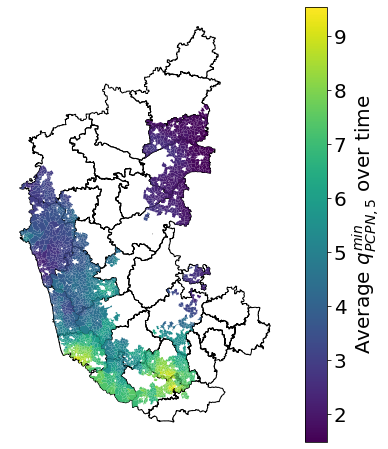

In [95]:
# Precipitation 9 min (zelfde als andere)

geo_PCPN1 = paddy_PCPN.copy()
geo_PCPN1['05_min'] = paddy_PCPN.loc[:,[col for col in paddy_PCPN.columns if '05_min' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_PCPN1.plot(column = '05_min', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{PCPN,5}^{min}$ over time')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\PCPN_9_min.png', bbox_inches='tight')


Text(496.9340000000001, 0.5, 'Average $q_{PCPN,9}^{min}$ over time')

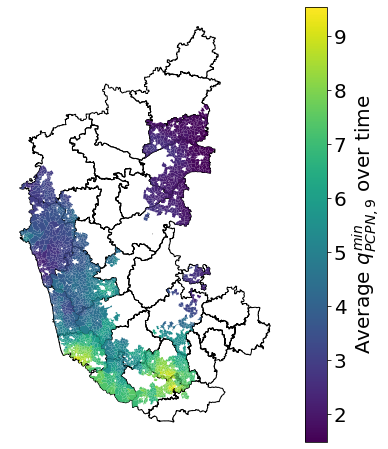

In [96]:
# Precipitation 9 min (zelfde als andere)

geo_PCPN1 = paddy_PCPN.copy()
geo_PCPN1['05_min'] = paddy_PCPN.loc[:,[col for col in paddy_PCPN.columns if '05_min' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_PCPN1.plot(column = '05_min', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{PCPN,9}^{min}$ over time')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\PCPN_9_min.png', bbox_inches='tight')


In [11]:
paddy_NDVI = functions_model.monthly_exploration(unique_paddy, parameters[0], paths[0], statistic, methods[0], 2016, 2018)
print('NDVI')
paddy_EVI = functions_model.monthly_exploration(unique_paddy, parameters[1], paths[1], statistic, methods[1], 2016, 2018)
print('EVI')
paddy_FAPAR = functions_model.monthly_exploration(unique_paddy, parameters[2], paths[2], statistic, methods[2], 2016, 2018)
print('FAPAR')
paddy_LAI = functions_model.monthly_exploration(unique_paddy, parameters[3], paths[3], statistic, methods[3], 2016, 2018)
print('LAI')
paddy_SIF = functions_model.monthly_exploration(unique_paddy, parameters[4], paths[4], statistic, methods[4], 2016, 2018)
print('SIF')
paddy_SSM = functions_model.monthly_exploration(unique_paddy, parameters[5], paths[5], statistic, methods[5], 2016, 2018)
print('SSM')
paddy_SUSM = functions_model.monthly_exploration(unique_paddy, parameters[6], paths[6], statistic, methods[6], 2016, 2018)
print('SUSM')
paddy_LSTd = functions_model.monthly_exploration(unique_paddy, parameters[7], paths[7], statistic, methods[7], 2016, 2018)
print('LSTd')
paddy_LSTn = functions_model.monthly_exploration(unique_paddy, parameters[8], paths[8], statistic, methods[8], 2016, 2018)
print('LSTn')
paddy_PCPN = functions_model.monthly_exploration(unique_paddy, parameters[9], paths[9], statistic, methods[9], 2016, 2018)
# monthly_exploration(geodataframe, parameter, path, statistic, method, beginyear, endyear):

NDVI
EVI
FAPAR
LAI
SIF
SSM
SUSM
LSTd
LSTn


In [97]:
paddy_PCPN = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_PCPN2.geojson')

In [98]:
paddy_NDVI = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_NDVI.geojson')
paddy_EVI = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_EVI.geojson')
paddy_FAPAR = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_FAPAR.geojson')
paddy_LAI = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_LAI.geojson')
paddy_SIF = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_SIF.geojson')
paddy_SSM = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_SSM.geojson')
paddy_SUSM = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_SUSM.geojson')
paddy_LSTd = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_LSTd.geojson')
paddy_LSTn = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_LSTn.geojson')
paddy_PCPN = gpd.read_file(r'D:\other_thesis\clean_sheet\files\df_independent\df_PCPN.geojson')

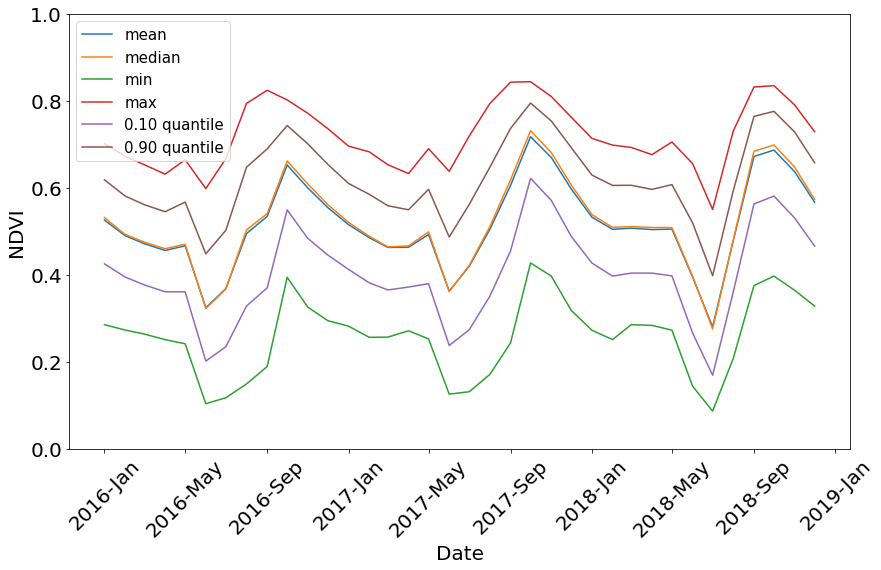

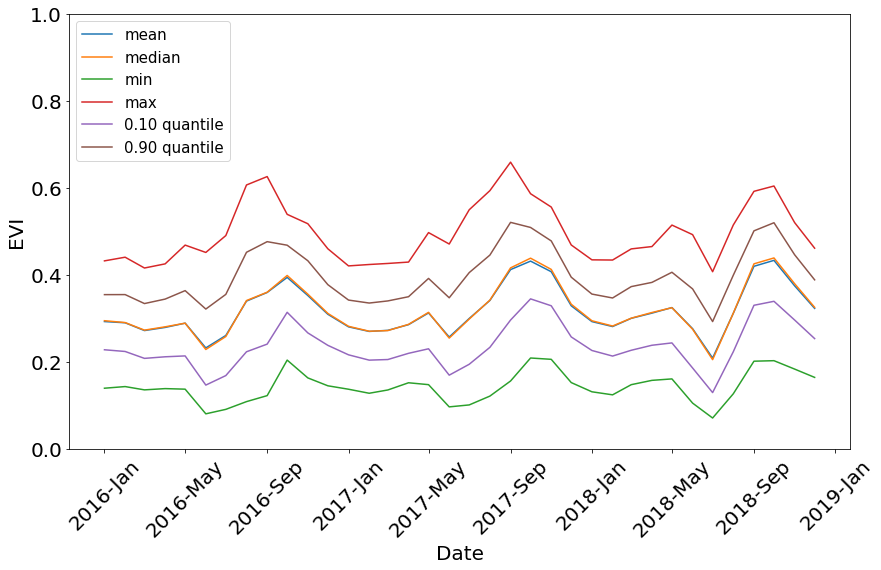

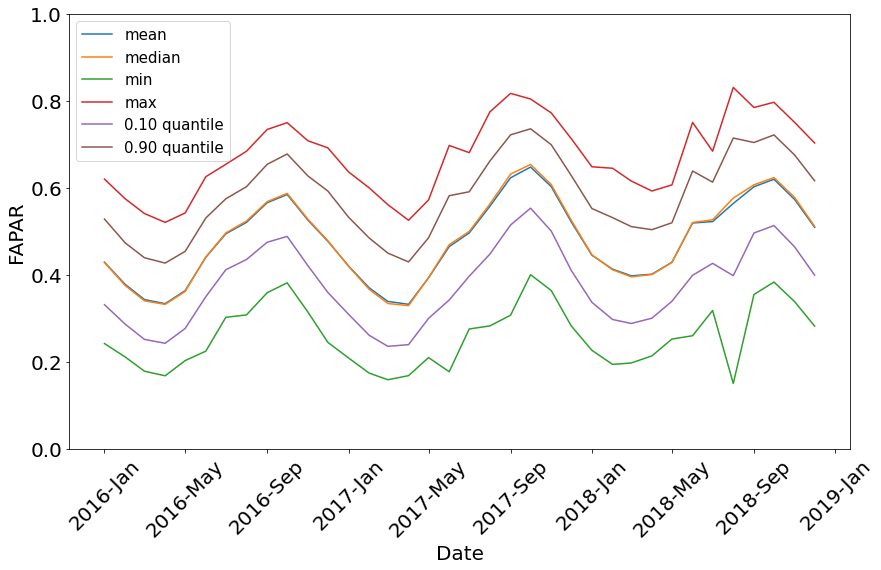

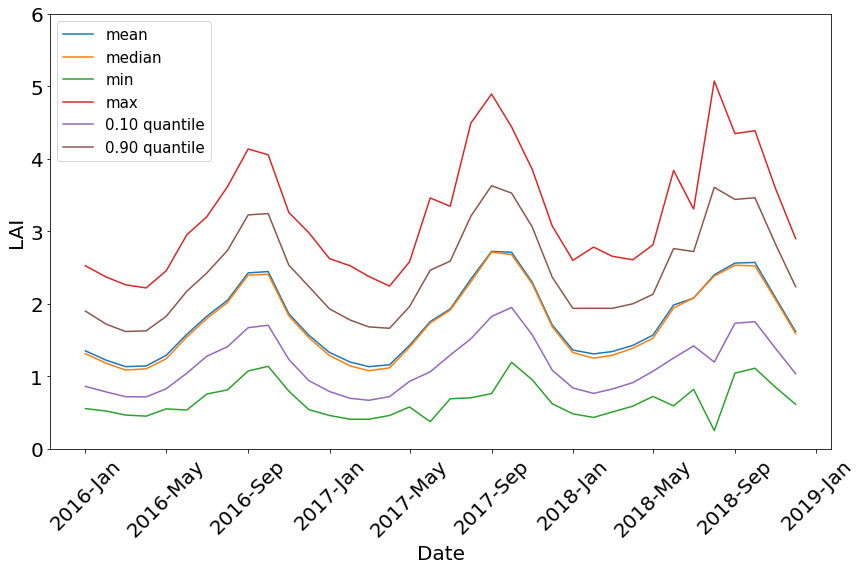

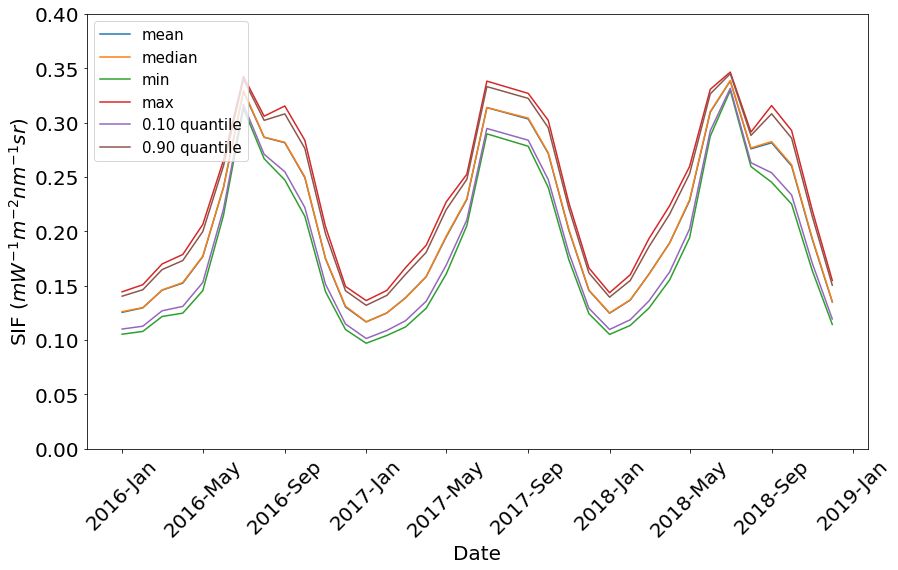

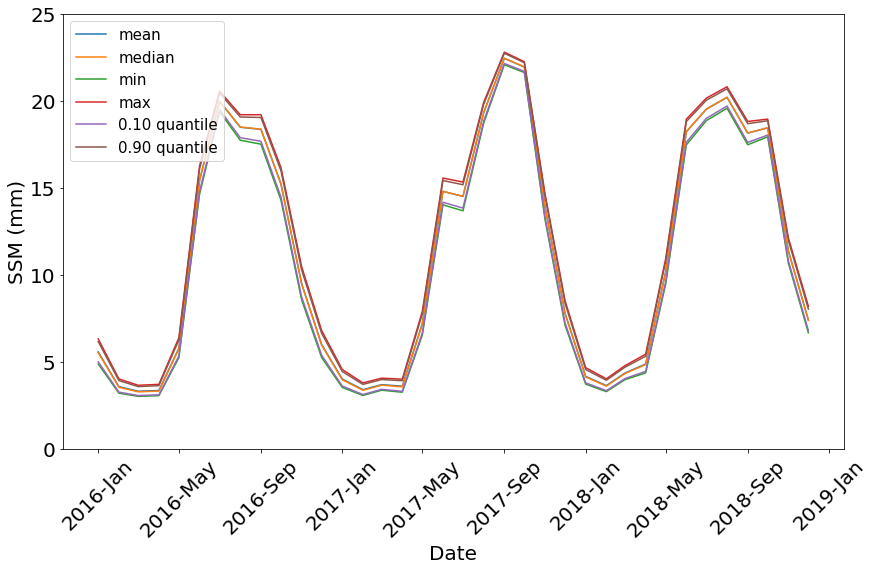

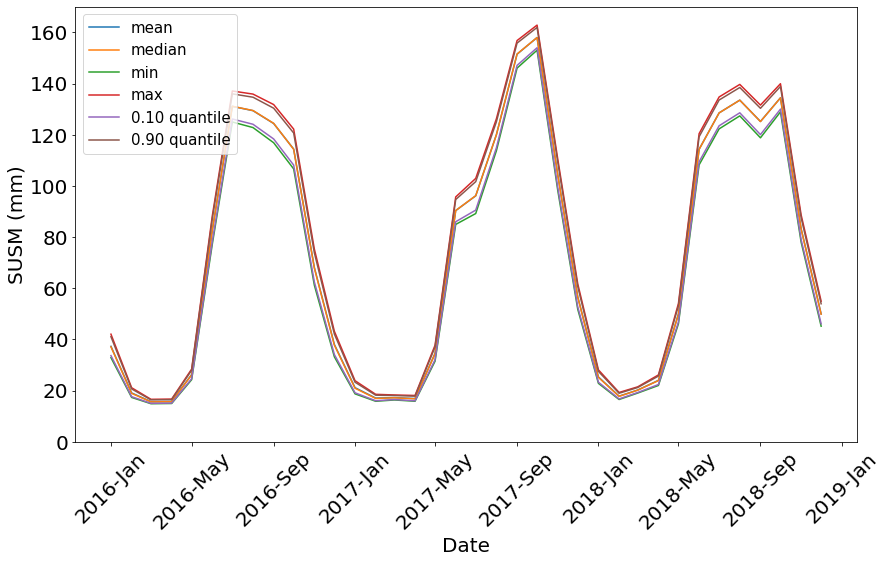

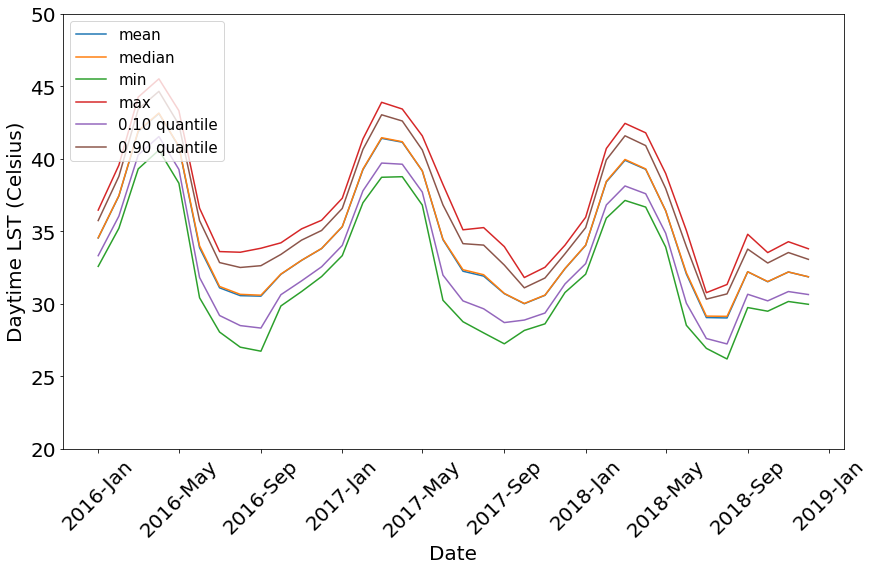

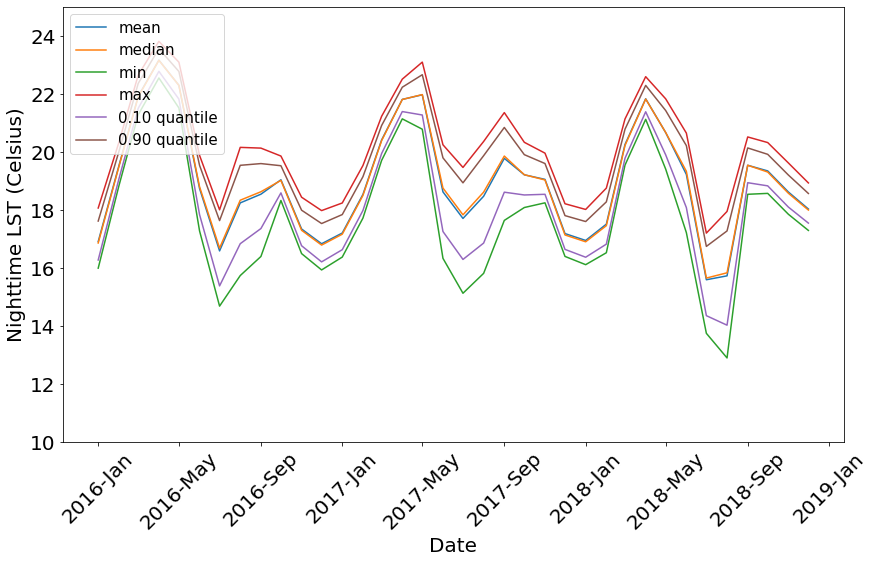

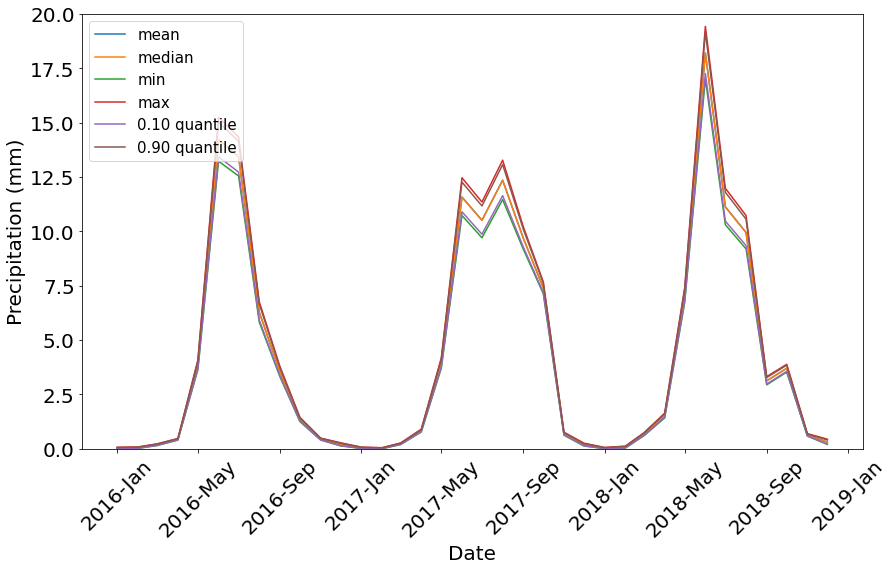

In [100]:
dataframe = [paddy_NDVI, paddy_EVI, paddy_FAPAR, paddy_LAI, paddy_SIF, paddy_SSM, paddy_SUSM, paddy_LSTd, paddy_LSTn, paddy_PCPN]
variable = ['NDVI', 'EVI', 'FAPAR', 'LAI', 'SIF', 'SSM', 'SUSM', 'LSTd', 'LSTn', 'PCPN']
unity = ['NDVI', 'EVI', 'FAPAR', 'LAI', 'SIF $(mW^{-1}m^{-2}nm^{-1}sr)$', 'SSM (mm)', 'SUSM (mm)', 'Daytime LST (Celsius)', 'Nighttime LST (Celsius)', 'Precipitation (mm)']
y_limit = [[0,1], [0,1], [0,1], [0,6], [0,0.4], [0,25], [0,170], [20,50], [10,25], [0,20]]
for i in range(len(dataframe)):
    plot_features_time(variable[i], dataframe[i], unity[i], y_limit[i])

Text(509.6840000000001, 0.5, 'Number of observations per district')

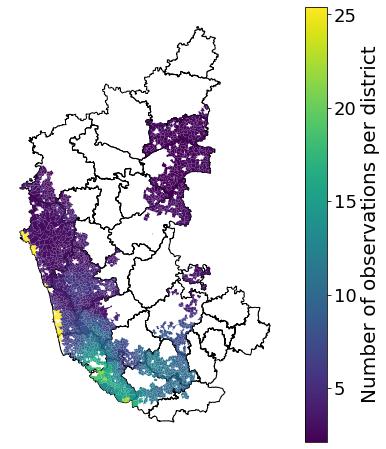

In [74]:
import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
paddy_SSM.plot(column = 'mean_05_min', ax=ax, legend=True)#, cmap = 'Blues') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Number of observations per district')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_observations.png', bbox_inches='tight')

In [73]:
plots_indep = unique_paddy.copy()
paddy_LSTn['mean_05_min'] = paddy_LSTn[['2016-05_min', '2017-05_min', '2018-05_min']].mean(axis=1)

plots_indep = unique_paddy.copy()
paddy_SSM['mean_05_min'] = paddy_SSM[['2016-05_min', '2017-05_min', '2018-05_min']].mean(axis=1)

plots_indep = unique_paddy.copy()
paddy_SUSM['mean_05_min'] = paddy_SUSM[['2016-05_min', '2017-05_min', '2018-05_min']].mean(axis=1)

In [ ]:
plots_indep.sort_values('mean_05_min')

In [ ]:
paddy_NDVI.sort_values('2016-05_min')['2018-05_min'].isna().sum()
plots_indep['mean_05_min'].isna().sum()
paddy_LSTn[['2016-05_min', '2017-05_min', '2018-05_min']].mean(axis=1).isna().sum()

In [ ]:
np.size(unique_paddy,0)

Text(522.4340000000001, 0.5, 'Number of observations per district')

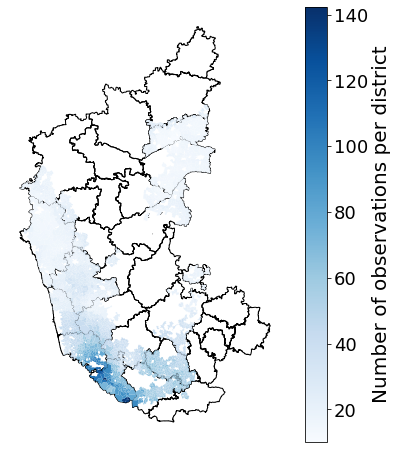

In [126]:
import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
paddy_SUSM.plot(column = 'mean_05_min', ax=ax, legend=True, cmap = 'Blues') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Number of observations per district')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_observations.png', bbox_inches='tight')

Text(509.6840000000001, 0.5, 'Number of observations per district')

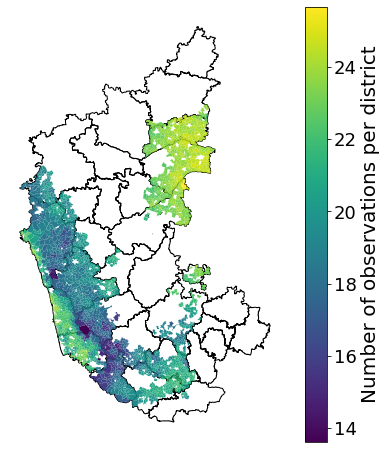

In [124]:
import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
paddy_LSTn.plot(column = 'mean_05_min', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Number of observations per district')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_observations.png', bbox_inches='tight')

## NEW!!

In [20]:
geo_SSM = paddy_SSM.copy()
geo_SSM['05_min'] = paddy_SSM.loc[:,[col for col in paddy_SSM.columns if '05_min' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_SSM.plot(column = '05_min', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{min,5}^{SSM}$ over time')#,fontsize= 20)
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\SSM_5_min.png', bbox_inches='tight')

In [117]:
[col for col in paddy_SSM.columns if '05_percentile_10' in col]

['2016-05_percentile_10', '2017-05_percentile_10', '2018-05_percentile_10']

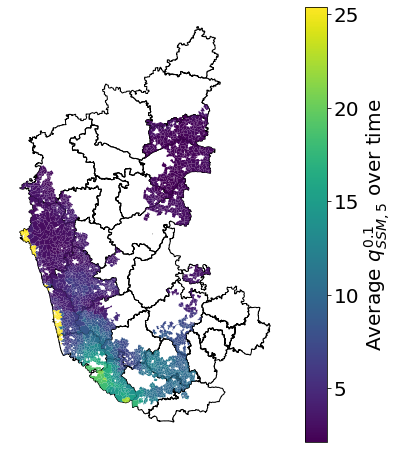

In [123]:
# Precipitation 9 min (zelfde als andere)

geo_SSM = paddy_SSM.copy()
geo_SSM['05_percentile_10'] = paddy_SSM.loc[:,[col for col in paddy_SSM.columns if '05_percentile_10' in col]].mean(axis=1)
geo_SSM['09_percentile_10'] = paddy_SSM.loc[:,[col for col in paddy_SSM.columns if '09_percentile_10' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_SSM.plot(column = '05_percentile_10', vmin=np.min(geo_SSM['05_percentile_10']), vmax=np.max(geo_SSM['05_percentile_10']), ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')



ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{SSM,5}^{0.1}$ over time')#,fontsize= 20)
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\SSM_5_min_final.png', bbox_inches='tight')


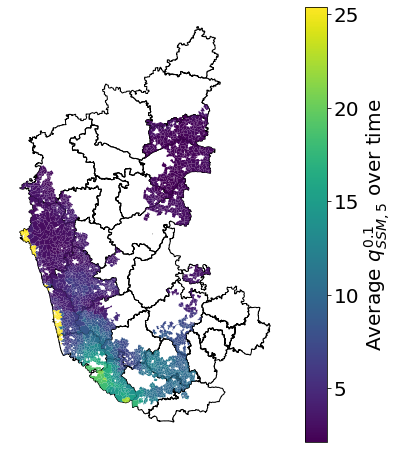

In [118]:
## SSM 05 10 percentile
geo_SSM = paddy_SSM.copy()
geo_SSM['05_percentile_10'] = paddy_SSM.loc[:,[col for col in paddy_SSM.columns if '05_percentile_10' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_SSM.plot(column = '05_percentile_10', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{SSM,5}^{0.1}$ over time')#,fontsize= 20)
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\SSM_5_10_quantile.png', bbox_inches='tight')

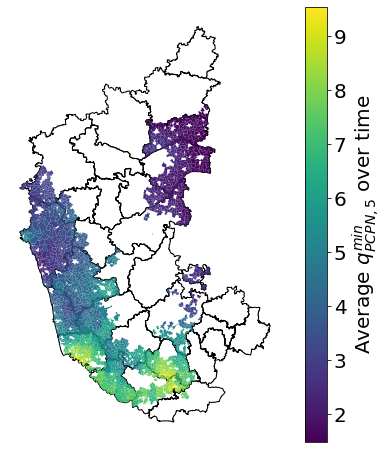

In [112]:
# Precipitation 9 min (zelfde als andere)

geo_PCPN = paddy_PCPN.copy()
geo_PCPN['05_min'] = paddy_PCPN.loc[:,[col for col in paddy_PCPN.columns if '05_min' in col]].mean(axis=1)
geo_PCPN['09_min'] = paddy_PCPN.loc[:,[col for col in paddy_PCPN.columns if '09_min' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_PCPN.plot(column = '05_min', vmin=np.min(geo_PCPN['05_min']), vmax=np.max(geo_PCPN['05_min']), ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{PCPN,5}^{min}$ over time')#,fontsize= 20)
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\PCPN_5_min_final.png', bbox_inches='tight')


Text(515.9340000000001, 0.5, 'Average $q_{FAPAR,8}^{0.1}$ over time')

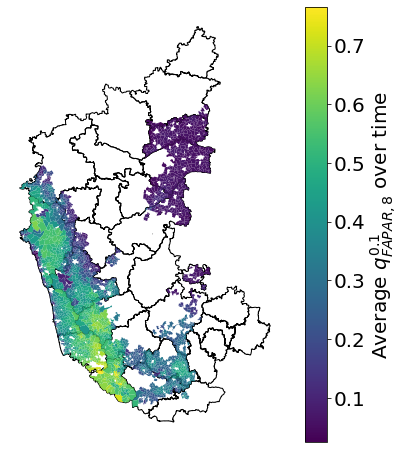

In [90]:
# FAPAR 08 10 percentile

geo_FAPAR = paddy_FAPAR.copy()
geo_FAPAR['05_10_percentile'] = paddy_FAPAR.loc[:,[col for col in paddy_FAPAR.columns if '05_percentile_10' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_FAPAR.plot(column = '05_10_percentile', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{FAPAR,8}^{0.1}$ over time')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\FAPAR_8_10percentile.png', bbox_inches='tight')


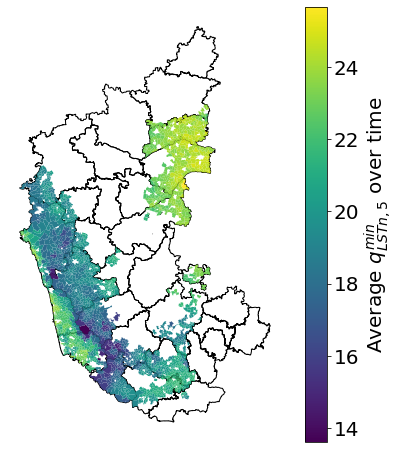

In [124]:
# FAPAR 08 10 percentile

geo_LSTn = paddy_LSTn.copy()
geo_LSTn['05_min'] = paddy_LSTn.loc[:,[col for col in paddy_LSTn.columns if '05_min' in col]].mean(axis=1)

import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
geo_LSTn.plot(column = '05_min', ax=ax, legend=True)#, cmap = 'RdBu_r') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Average $q_{LSTn,5}^{min}$ over time')#,fontsize= 20)
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\LSTn_05_min_final.png', bbox_inches='tight')


Text(496.9340000000001, 0.5, 'Number of observations per district')

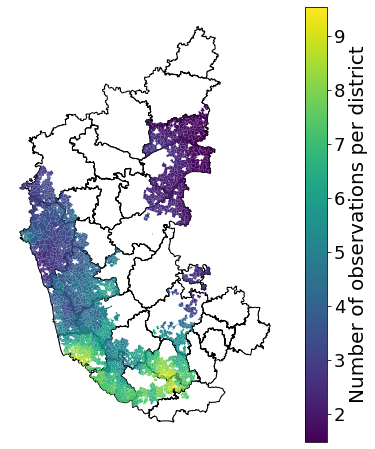

In [123]:
import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

paddy_PCPN['mean_05_min'] = paddy_PCPN[['2016-05_min', '2017-05_min', '2018-05_min']].mean(axis=1)
matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
paddy_PCPN.plot(column = 'mean_05_min', ax=ax, legend=True)#, cmap = 'Blues') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Number of observations per district')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_observations.png', bbox_inches='tight')

Text(515.9340000000001, 0.5, 'Number of observations per district')

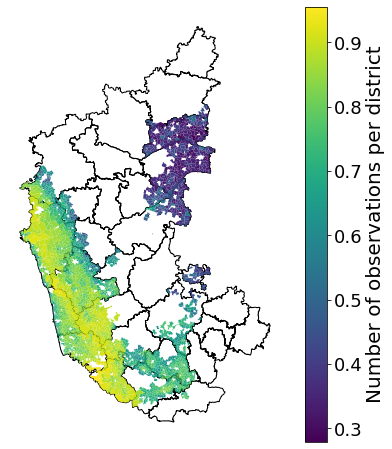

In [122]:
import matplotlib        as mpl

cmap_b = mpl.cm.Blues(np.linspace(0,1,20))
cmap_b = mpl.colors.ListedColormap(cmap_b[10:,:-1])

paddy_NDVI['mean_05_max'] = paddy_NDVI[['2016-05_max', '2017-05_max', '2018-05_max']].mean(axis=1)
paddy_NDVI['mean_06_max'] = paddy_NDVI[['2016-06_max', '2017-06_max', '2018-06_max']].mean(axis=1)
paddy_NDVI['mean_07_max'] = paddy_NDVI[['2016-07_max', '2017-07_max', '2018-07_max']].mean(axis=1)
paddy_NDVI['mean_08_max'] = paddy_NDVI[['2016-08_max', '2017-08_max', '2018-08_max']].mean(axis=1)
paddy_NDVI['mean_09_max'] = paddy_NDVI[['2016-09_max', '2017-09_max', '2018-09_max']].mean(axis=1)
paddy_NDVI['mean_10_max'] = paddy_NDVI[['2016-10_max', '2017-10_max', '2018-10_max']].mean(axis=1)

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
paddy_NDVI.plot(column = 'mean_05_max', ax=ax, legend=True)#, cmap = 'BuGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Number of observations per district')#,fontsize= 20)
#plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_observations.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y-%b')
fig,ax = plt.subplots(figsize=(14,8))
for i in ['mean', 'median', 'min', 'max', 'percentile_10', 'percentile_90']:
    new = paddy_NDVI.loc[:,[col for col in paddy_NDVI.columns if i in col]].mean()
    new.index = [re.search('.*\_(.*?)\_.[a-z]', x).group(1) for x in new.index]
    new.index = pd.to_datetime(new.index)
    #plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
    plt.plot(new.index, new, label= i)
ax.set_xticklabels(new.index, rotation=45)
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('MAE (kg/ha)', fontsize = 14)
plt.ylabel('Amount', fontsize = 14)
plt.legend(fontsize=10)
plt.ylim([0,1])
plt.show()
#plot_features_time(paddy_NDVI, 'NDVI', [0,1])

## PREVIOUS DISTRICT YIELD

In [ ]:
# Plot Yield(KG/Ha)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
district_paddy_2016.plot(column = 'Yield(Kg/Ha)', ax=ax, legend=True, vmin = 0, vmax = max(district_paddy_2016['Yield(Kg/Ha)']), cmap = 'RdYlGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Actual average yield (kg/ha)')#,fontsize= 20)

import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
district_paddy_2017.plot(column = 'Yield(Kg/Ha)', ax=ax, legend=True, vmin = 0, vmax = max(district_paddy_2017['Yield(Kg/Ha)']), cmap = 'RdYlGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Actual average yield (kg/ha)')#,fontsize= 20)

import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
Karnataka_districts.plot(ax=ax,facecolor="none")
district_paddy_2018.plot(column = 'Yield(Kg/Ha)', ax=ax, legend=True, vmin = 0, vmax = max(district_paddy_2018['Yield(Kg/Ha)']), cmap = 'RdYlGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Actual average yield (kg/ha)')#,fontsize= 20)

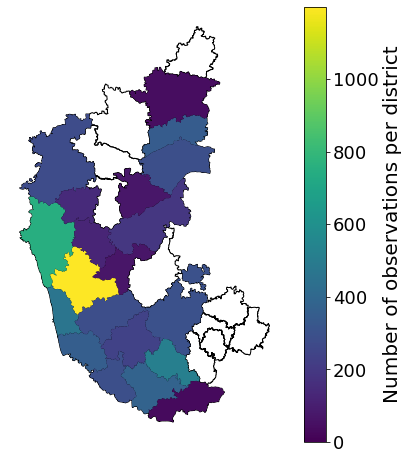

In [119]:
import matplotlib
sizes = pd.DataFrame({'Count': data_paddy.groupby('District').size()}).reset_index()
obs_count_district = Karnataka_districts[['District', 'geometry']].merge(sizes, how = 'left', on = ['District']).sort_values('Count', ascending = False, ignore_index = True)

obs_count_district['coords'] = obs_count_district['geometry'].apply(lambda x: x.representative_point().coords[:])
obs_count_district['coords'] = [coords[0] for coords in obs_count_district['coords']]


matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
obs_count_district.plot(ax=ax,facecolor="none")
obs_count_district.plot(column = 'Count', ax=ax, legend=True, vmin = 0, vmax = max(obs_count_district['Count']))#, cmap = 'YlOrBr') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
# for idx, row in obs_count_district.iterrows():
#     plt.annotate(text=row['District'], xy=row['coords'],
#                  horizontalalignment='center', fontsize=11)#, weight='bold')

ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=18)
#plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
cb_ax.set_ylabel('Number of observations per district')#,fontsize= 20)
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_observations.png', bbox_inches='tight')

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
for i in [distri, district_paddy_2016, district_paddy_2017, district_paddy_2018]:
    fig,ax = plt.subplots(figsize=(8,8))
    Karnataka_districts.plot(ax=ax,facecolor="none")
    i.plot(column = 'Yield(Kg/Ha)', ax=ax, legend=True, vmin = 0, vmax = max(district_paddy_2017['Yield(Kg/Ha)']), cmap = 'RdYlGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
    ax.axis('off')
    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=18)
    #plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
    cb_ax.set_ylabel('Actual average yield (kg/ha)')#,fontsize= 20)

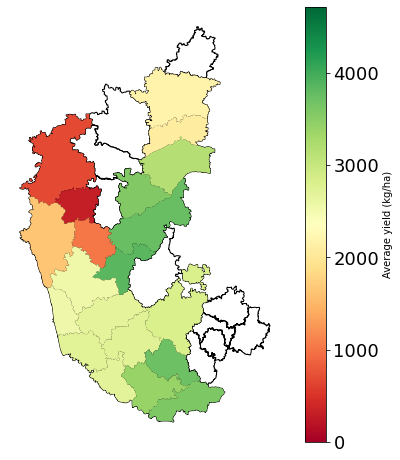

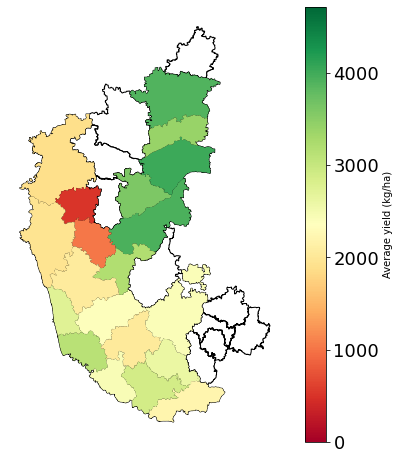

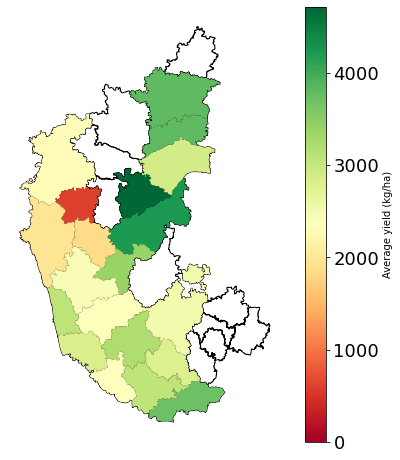

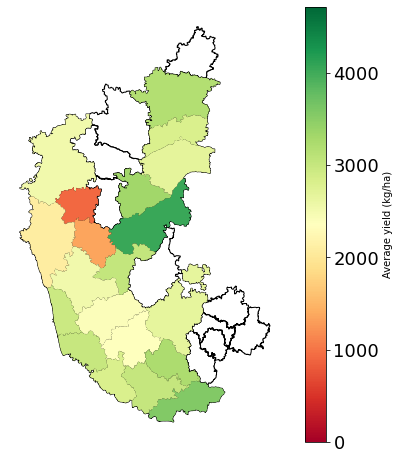

In [12]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

district_paddy_2015t = district_paddy_2015[district_paddy_2015['District'].isin(data_paddy['District'].unique())]
district_paddy_2016t = district_paddy_2016[district_paddy_2016['District'].isin(data_paddy['District'].unique())]
district_paddy_2017t = district_paddy_2017[district_paddy_2017['District'].isin(data_paddy['District'].unique())]
district_paddy_2018t = district_paddy_2018[district_paddy_2018['District'].isin(data_paddy['District'].unique())]

for i in [district_paddy_2015t, district_paddy_2016t, district_paddy_2017t, district_paddy_2018t]:
        fig,ax = plt.subplots(figsize=(8,8))
        Karnataka_districts.plot(ax=ax,facecolor="none")
        i.plot(column = 'Yield(Kg/Ha)', ax=ax, legend=True, vmin = 0, vmax = max(district_paddy_2017t['Yield(Kg/Ha)']), cmap = 'RdYlGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
        ax.axis('off')
        cb_ax = fig.axes[1] 
        cb_ax.tick_params(labelsize=18)
        #plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
        cb_ax.set_ylabel('Average yield (kg/ha)')#,fontsize= 20)
        plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_yield'+ str(i.Year.unique()[0]) + '.png', bbox_inches='tight')
        

In [12]:
district_yield_gdf = district_yield.merge(Karnataka_districts[['District', 'geometry']], how = 'left', on = ['District'])
district_yield_gdf = gpd.GeoDataFrame(district_yield_gdf, geometry = district_yield_gdf.geometry, crs = {'init': 'epsg:4326'})

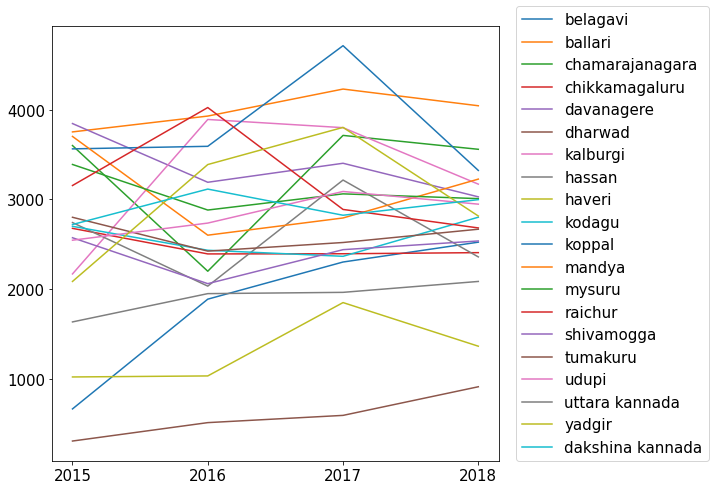

In [181]:
#plot(district_paddy_2016['Year'], district_paddy_2016['Yield(Kg/Ha)'])
matplotlib.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(figsize=(8,8))
for i in district_yield_gdf['District'].unique():
    # temp = df.loc[:,[col for col in df.columns if param[i] in col]].mean()
    # temp.index = [re.search('(.*?)\_.[a-z]', x).group(1) for x in temp.index]
    # temp.index = pd.to_datetime(temp.index)
    # plt.plot(temp.index, temp, label= legend_labels[i])
    #fig,ax = plt.subplots(figsize=(8,8))
    
    plt.rcParams["figure.figsize"] = (15,15)
    if i in data_paddy['District'].unique():
        temp = district_yield_gdf[(district_yield_gdf['District'] == i) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif')]# & (district_yield_gdf['Year'] <= 2017)]
        plt.plot(temp['Year'], temp['Yield(Kg/Ha)'], label= i)
#ax.set_xticklabels([2015, 2016, 2017, 2018], rotation=45)
ax.set_xticks([2015, 2016, 2017, 2018])
plt.legend(loc=(1.04, 0))#'upper right')#alignment='right')


In [15]:
(1199 + 751 + 513 + 464 + 379) / 6315

0.5235154394299287

In [14]:
district_yield_interest = district_yield_gdf[(district_yield_gdf['District'].isin(data_paddy['District'].unique())) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif')]# & (district_yield_gdf['Year'] <= 2017)]

In [45]:
district_yield_gdf.drop_duplicates(subset = 'District')

,District,Year,Season,Crop,Area(Ha),Production(Kg),Yield(Kg/Ha),geometry
0,bagalkot,2015,Kharif,maize (makka),27789,102932000,3704.055562,"POLYGON ((75.58306 16.43044, 75.58368 16.43155..."
4,bengaluru (rural),2015,Kharif,maize (makka),14695,41769000,2842.395373,"POLYGON ((77.20133 13.26549, 77.20135 13.26546..."
8,belagavi,2015,Kharif,maize (makka),96482,202197000,2095.696607,"MULTIPOLYGON (((75.03478 15.66986, 75.03412 15..."
12,ballari,2015,Kharif,maize (makka),91764,241564000,2632.448455,"POLYGON ((76.67771 14.89294, 76.67771 14.89286..."
16,bengaluru (urban),2015,Kharif,maize (makka),917,2505000,2731.733915,"MULTIPOLYGON (((77.33517 12.94722, 77.33513 12..."
20,bidar,2015,Kharif,maize (makka),1235,2330000,1886.639676,"MULTIPOLYGON (((77.05823 18.15786, 77.05929 18..."
24,vijayapura,2015,Kharif,maize (makka),27783,46189000,1662.491452,"POLYGON ((76.41897 16.58031, 76.41905 16.57978..."
28,chamarajanagara,2015,Kharif,maize (makka),36049,149109000,4136.286721,"POLYGON ((77.16687 12.30685, 77.16676 12.30718..."
32,chikkaballapura,2015,Kharif,maize (makka),58407,195979000,3355.402606,"POLYGON ((78.19397 13.54825, 78.19398 13.54823..."
36,chikkamagaluru,2015,Kharif,maize (makka),25831,61668000,2387.364020,"POLYGON ((75.89467 13.81112, 75.89582 13.81122..."


In [50]:
district_diff = pd.DataFrame({'District': data_paddy['District'].unique()})
district_diff['2015'] = np.nan
district_diff['2016'] = np.nan
district_diff['2017'] = np.nan
district_diff['2018'] = np.nan
for i in range(np.size(district_diff,0)):
    district_diff.loc[i,'2015'] = int(district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2015)]['Yield(Kg/Ha)'])
    district_diff.loc[i,'2016'] = int(district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2016)]['Yield(Kg/Ha)'])
    district_diff.loc[i,'2017'] = int(district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2017)]['Yield(Kg/Ha)'])
    district_diff.loc[i,'2018'] = int(district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2018)]['Yield(Kg/Ha)'])
    # district_diff.loc[i, 'diff_2016'] = district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2016)]['Yield(Kg/Ha)'] - district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2015)]['Yield(Kg/Ha)']
    # district_diff.loc[i, 'diff_2017'] = district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2017)]['Yield(Kg/Ha)'] - district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2016)]['Yield(Kg/Ha)']
    # district_diff.loc[i, 'diff_2018'] = district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2018)]['Yield(Kg/Ha)'] - district_yield_gdf[(district_yield_gdf['District'] == district_diff.loc[i, 'District']) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif') & (district_yield_gdf['Year'] == 2017)]['Yield(Kg/Ha)']

district_diff['diff_2016'] = abs(district_diff['2016'] - district_diff['2015'])
district_diff['diff_2017'] = abs(district_diff['2017'] - district_diff['2016'])
district_diff['diff_2018'] = abs(district_diff['2018'] - district_diff['2017'])
district_diff = Karnataka_districts[['District', 'geometry']].merge(district_diff, how = 'left', on = ['District'])
district_diff = district_diff.dropna()

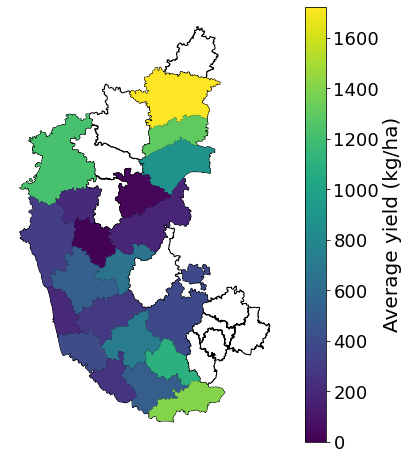

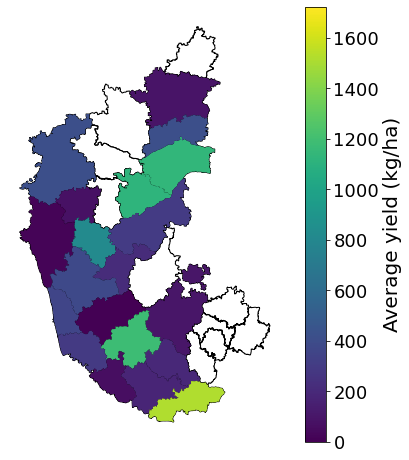

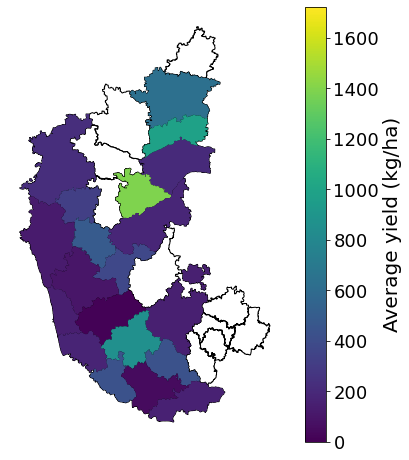

In [55]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

for i in ['diff_2016', 'diff_2017', 'diff_2018']:
        fig,ax = plt.subplots(figsize=(8,8))
        Karnataka_districts.plot(ax=ax,facecolor="none")
        district_diff.plot(column = i, ax=ax, vmin = 0, vmax = max(district_diff['diff_2016']), legend=True)#, cmap = 'RdYlGn') #, legend_kwds = {'label': 'MAE (Kg/Ha)'} # RdYlGn
        ax.axis('off')
        cb_ax = fig.axes[1] 
        cb_ax.tick_params(labelsize=18)
        #plt.legend(['MAE (Kg/Ha)'], fontsize = 30)
        cb_ax.set_ylabel('Average yield (kg/ha)')#,fontsize= 20)
        #plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_yield'+ str(i.Year.unique()[0]) + '.png', bbox_inches='tight')
        

In [ ]:
for i in obs_count_district.iloc[:5,0]:
    # temp = df.loc[:,[col for col in df.columns if param[i] in col]].mean()
    # temp.index = [re.search('(.*?)\_.[a-z]', x).group(1) for x in temp.index]
    # temp.index = pd.to_datetime(temp.index)
    # plt.plot(temp.index, temp, label= legend_labels[i])
    #fig,ax = plt.subplots(figsize=(8,8))
    
    plt.rcParams["figure.figsize"] = (15,15)
    if i in data_paddy['District'].unique():
        temp = district_yield_gdf[(district_yield_gdf['District'] == i) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif')]# & (district_yield_gdf['Year'] <= 2017)]

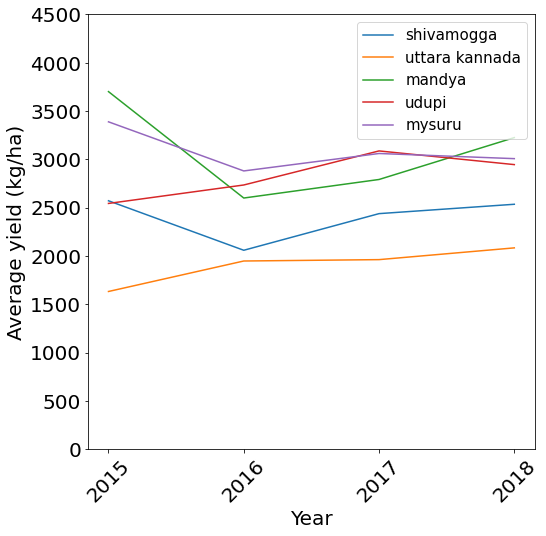

In [57]:
#plot(district_paddy_2016['Year'], district_paddy_2016['Yield(Kg/Ha)'])

matplotlib.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(figsize=(8,8))
for i in obs_count_district.iloc[:5,0]:
    # temp = df.loc[:,[col for col in df.columns if param[i] in col]].mean()
    # temp.index = [re.search('(.*?)\_.[a-z]', x).group(1) for x in temp.index]
    # temp.index = pd.to_datetime(temp.index)
    # plt.plot(temp.index, temp, label= legend_labels[i])
    #fig,ax = plt.subplots(figsize=(8,8))
    
    plt.rcParams["figure.figsize"] = (15,15)
    if i in data_paddy['District'].unique():
        temp = district_yield_gdf[(district_yield_gdf['District'] == i) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif')]# & (district_yield_gdf['Year'] <= 2017)]
        plt.plot(temp['Year'], temp['Yield(Kg/Ha)'], label= i)
ax.set_xticklabels([2015, 2016, 2017, 2018], rotation=45)
ax.set_xticks([2015, 2016, 2017, 2018], rotation=45)
plt.ylim(0,4500)
plt.legend(loc='upper right', fontsize=15)#alignment='right')loc=(1.04, 0))
plt.xlabel('Year')
plt.ylabel('Average yield (kg/ha)')
plt.savefig(r'D:\other_thesis\clean_sheet\files\results\geographic_plots\district_yield_plot5.png', bbox_inches='tight')

In [ ]:
#plot(district_paddy_2016['Year'], district_paddy_2016['Yield(Kg/Ha)'])
matplotlib.rcParams.update({'font.size': 15})
for i in district_yield_gdf['District'].unique():
    # temp = df.loc[:,[col for col in df.columns if param[i] in col]].mean()
    # temp.index = [re.search('(.*?)\_.[a-z]', x).group(1) for x in temp.index]
    # temp.index = pd.to_datetime(temp.index)
    # plt.plot(temp.index, temp, label= legend_labels[i])
    #fig,ax = plt.subplots(figsize=(8,8))
    plt.rcParams["figure.figsize"] = (15,15)
    if i in data_paddy['District'].unique():
        temp = district_yield_gdf[(district_yield_gdf['District'] == i) & (district_yield_gdf['Crop'] == 'paddy') & (district_yield_gdf['Season'] == 'Kharif')]# & (district_yield_gdf['Year'] <= 2017)]
        plt.plot(temp['Year'], temp['Yield(Kg/Ha)'], label= i)
#ax.set_xticklabels(temp.index, rotation=45)
plt.legend()#alignment='right')
plt.show()
